In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import os
import os, sklearn, pandas, numpy as np, random
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from sklearn.utils import shuffle
import imp
from sklearn.preprocessing import LabelBinarizer
# from pcanet import PCANet
from pcanet import PCANet
import numpy as np
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# set cwd back to default
os.chdir('../')
os.getcwd()

'/Users/Tristan/Downloads/dog-breed-identification/src'

In [3]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
# from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'validation' = ['img_name']
    , 'labels' = pandas.df('img_name','label')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


In [4]:
import data # src/data.py
dataset = data.init_dataset()

### Select the amount of classes that will be used

In [5]:
# pick the n classes with the most occuring instances
amt = 5
classes = data.top_classes(dataset.labels, amt)
classes

['paper', 'glass', 'plastic', 'metal', 'cardboard']

In [6]:
def extract_topx_classes(classes, train_or_test):
    name_list = []
    n_per_class = []
    tail = '.jpg'
    for cls in classes:
        print(cls)
        names = data.items_with_label(dataset.labels, cls)
        if train_or_test == 'train':
            train_names = [f for f in names if (f) in dataset.train]
        if train_or_test == 'test':
            train_names = [f for f in names if (f) in dataset.test]
        if train_or_test == 'validation':
            train_names = [f for f in names if (f) in dataset.validation]
        name_list.append(train_names)
        n_per_class.append(len(train_names))

    n = min(n_per_class)
    # (optional) reduce n to check whether the model can rember its input
#     reduced_n = 50
#     if n > reduced_n:    n = reduced_n
    x = []
    for ls in name_list:
        for name in ls:
            x.append(name)
    random.shuffle(x)
    return x

x_train = extract_topx_classes(classes, 'train')
x_test = extract_topx_classes(classes, 'test')
x_validation = extract_topx_classes(classes, 'validation')


paper
glass
plastic
metal
cardboard
paper
glass
plastic
metal
cardboard
paper
glass
plastic
metal
cardboard


In [ ]:
print(x_train[0:10])


### Load and convert images

Training data

In [7]:
x_train, y_train, n = data.extract_all(dataset, x_train)
# y_test = y_train


('extract all data:', 1940)


In [ ]:
print(y1_train)

In [ ]:
plt.imshow(x_train[0])

Testing data

In [8]:
x_test, y_test, n = data.extract_all_test(dataset, x_test)


('extract all data:', 300)


Validation data

In [9]:
x_validation, y_validation, n  = data.extract_all_validation(dataset, x_validation)


('extract all data:', 150)


Convert labels and determine input and output shape for model

In [ ]:
imp.reload(data)

In [10]:
# y_train, y_test, y_validation = data.labels_to_vectors(dataset, y_train, y_test, y_validation)
y_train = data.one_hot(y_train)
y_test = data.one_hot(y_test)
y_validation = data.one_hot(y_validation)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label


In [ ]:
print(x1_train[0:10])
print(y_train[0:10])

    

Initiate VG16 network and add extra layers

In [58]:
from keras.models import Model 

def get_model(learn_rate=0.0001, batches=10, dropout=0.10):
    # build the VGG16 network
    model = applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape )
    print('Model loaded.')

    # build a classifier model to put on top of the convolutional model
    # top_model = Sequential()
    # top_model.add(Flatten(input_shape=model.output_shape[1:]))
    # top_model.add(Dense(256, activation='relu'))
    # top_model.add(Dropout(0.5))
    # top_model.add(Dense(1, activation='sigmoid'))

    for layer in model.layers[:13]:
        layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = (Dropout(dropout))(x)
    x = (Dense(2048, activation='relu'))(x) #128
    x = (Dense(2048, activation='relu'))(x) #128
    x = (Dense(1024, activation='relu'))(x)
    # softmax output to get probability distribution
    predictions = Dense(output_length, activation="softmax")(x) #activation="softmax"


    # creating the final model 
    model_final = Model(input = model.input, output = predictions)

    # Adam, SGD
    # sgd = Keras.optimizers.SGD(lr=0.01, clipnorm=1.)
    optimizer = optimizers.Adam(lr=learn_rate)

    # compile the model 
    model_final.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy',
        'mean_squared_error','categorical_crossentropy','top_k_categorical_accuracy'])
    
    return model_final

### Hyperparameter selection

In [ ]:

from sklearn.grid_search import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import time

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

batches = [5, 10, 20]
learn_rate = [0.0001, 0.001, 0.01]
dropout = [0.1, 0.3, 0.5] # most used values
param_grid = dict(learn_rate=learn_rate, batch_size=batches, dropout=dropout)

# tune the hyperparameters via a randomized search
model = KerasClassifier(build_fn=get_model, verbose=0)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid)
start = time.time()
grid.fit(x_validation, y_validation)
 
# evaluate the best randomized searched model on the testing
# data
print("[INFO] randomized search took {:.2f} seconds".format(
    time.time() - start))
acc = grid.score(x_validation, y_validation)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] randomized search best parameters: {}".format(
    grid.best_params_))

data augmentation

In [43]:
#Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    rotation_range = 30)

validate_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    rotation_range = 30)

### Train the model

In [60]:
# n epochs = n iterations over all the training data
batch_size = 10
epochs = 15

### With data augmentation

In [ ]:
model_final_augmentation = get_model()

train_datagen.fit(x_train)
val = validate_datagen.fit(x_validation)
model_final_augmentation.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                                                           epochs=epochs, 
                                                           callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])
        


Model loaded.


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/15
132/194 [===================>..........] - ETA: 10:44 - loss: 1.3047 - acc: 0.4371 - mean_squared_error: 0.1346 - categorical_crossentropy: 1.3047 - top_k_categorical_accuracy: 1.0000

### Without data augmentation

In [15]:
model_final = get_model()

from keras.callbacks import TensorBoard
model_final.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])

model.save(config.dataset_dir + 'models/')

Model loaded.


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/15
1940/1940 [==============================] - 1173s 605ms/step - loss: 5.6430 - acc: 0.5840 - mean_squared_error: 0.1595 - categorical_crossentropy: 5.6430 - top_k_categorical_accuracy: 1.0000
Epoch 2/15
1940/1940 [==============================] - 1246s 642ms/step - loss: 4.6797 - acc: 0.6840 - mean_squared_error: 0.1241 - categorical_crossentropy: 4.6797 - top_k_categorical_accuracy: 1.0000
Epoch 3/15
1940/1940 [==============================] - 1241s 640ms/step - loss: 4.0543 - acc: 0.7232 - mean_squared_error: 0.1077 - categorical_crossentropy: 4.0543 - top_k_categorical_accuracy: 1.0000
Epoch 4/15
1940/1940 [==============================] - 1288s 664ms/step - loss: 2.7610 - acc: 0.8015 - mean_squared_error: 0.0770 - categorical_crossentropy: 2.7610 - top_k_categorical_accuracy: 1.0000
Epoch 5/15
1940/1940 [==============================] - 1221s 630ms/step - loss: 1.7671 - acc: 0.8562 - mean_squared_error: 0.0549 - categorical_crossentropy: 1.7671 - top_k_categorical_ac

NameError: name 'model' is not defined

### save the model

In [27]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model_final_augmentation.to_json()
with open(config.dataset_dir + 'models/' + "cnntransfer_augm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final_augmentation.save_weights(config.dataset_dir + 'models/' + "cnntransferweights_augmen.h5", "w")
print("Saved model to disk")


Saved model to disk


### load a model

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

## running tests


In [41]:
import numpy as np
# import sklearn.metrics.confusion_matrix

def evaluate(model):
    cvscores = []
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

evaluate(model_final_augmentation)

acc: 54.67%
54.67% (+/- 0.00%)


In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
    

In [29]:
import tensorflow as tf

y_pred_class = model_final.predict(x_test)
# con = tf.confusion_matrix(labels=y_test, predictions=y_pred_class )
# print(con)

y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred_class ]


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
print(conf_mat)
# def confusion_matrix(model, x_test)
#     y_pred_class = model_final.predict(X_test)
#     con = tf.confusion_matrix(labels=y_train, predictions=y_pred_class )
#     print(cont)


[[29  1  1 24  5]
 [ 0 41  2  1 16]
 [ 0 11 34  1 14]
 [ 0  0  0 55  5]
 [ 0  5  0  4 51]]


In [40]:
num_classes = 5

# from lable to categorial
y_categorical = y_pred_class
# from categorial to lable indexing
y_pred = y_categorial.argmax(1)
print(y_pred)
# plot_confusion_matrix(conf_mat, classes)

[[1.07322677e-25 6.23139972e-23 5.47258744e-25 1.00000000e+00
  2.43150552e-17]
 [1.08412965e-20 1.59648637e-20 1.00000000e+00 1.78932823e-23
  3.43413177e-16]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00]
 ...
 [6.13331655e-23 1.03271442e-18 3.36715216e-19 1.00000000e+00
  1.62746783e-13]
 [4.88326718e-13 6.10503293e-13 1.00000000e+00 1.92685326e-10
  1.71265224e-09]
 [3.08337860e-07 9.26659167e-01 4.66392899e-04 8.69648939e-04
  7.20044672e-02]]
[3 2 4 4 1 1 4 3 2 4 2 3 4 3 4 1 4 3 2 4 3 2 1 1 4 4 3 0 3 4 4 3 3 4 4 3 4
 4 1 3 4 2 3 4 4 0 1 4 2 0 0 1 3 0 3 4 0 3 1 1 3 3 1 2 1 3 4 4 4 4 3 1 0 4
 3 2 3 4 1 4 2 4 2 2 0 1 3 0 3 3 4 4 4 4 4 4 3 3 1 4 1 1 3 3 0 3 2 0 3 4 4
 3 0 4 4 2 0 4 0 2 2 3 3 0 4 4 2 1 1 3 4 3 4 4 2 3 1 4 4 2 4 3 2 4 4 1 0 4
 0 4 1 1 2 4 3 4 3 3 4 4 1 1 2 4 3 1 1 3 1 3 0 1 4 1 3 4 3 0 3 4 4 4 1 1 3
 3 3 3 4 0 3 4 3 1 3 2 2 1 4 4 0 3 4 1 4 1 1 2 3 0 1 3 4 1 2 1 1 3 4 1 0 3
 1 3 3 4 4 1 1 0 4 4 3 1 3 3 1 2 4 1 3 3 2 1 4 1 3 2 4 3 3 1 3 4

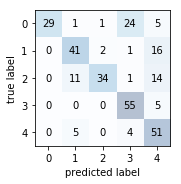

In [32]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat)

### Baseline

In [ ]:

pcanet = PCANet(
        image_shape= (256),
        filter_shape_l1=2, step_shape_l1=1, n_l1_output=4,
        filter_shape_l2=2, step_shape_l2=1, n_l2_output=4,
        block_shape=2
    )
pcanet.validate_structure()

pcanet.fit(x_train)
X_train = pcanet.transform(x_train)
X_test = pcanet.transform(x_test)

model = RandomForestClassifier(n_estimators=100, random_state=1234, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: " + str(accuracy))
